In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Load the dataset
df = pd.read_csv('training_datasets/bitcoin_prediction_dataset.csv', parse_dates=['date'])

# Sort by date
df = df.sort_values('date')
print(df.head(1))
# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['bitcoin_price', 'sp500_price', 'gold_price', 'usd_index', 'oil_price', 'volatility_index', 'interest_rate']])

print(scaled_data[0:2])
# Create sequences for the LSTM model
def create_sequences(data, lookback, forecast_horizon=7):
    X, y = [], []
    for i in range(lookback, len(data) - forecast_horizon + 1):
        X.append(data[i - lookback:i])
        y.append(data[i:i + forecast_horizon, 0])  # Bitcoin price for the next 7 days
    return np.array(X), np.array(y)

lookback = 30  # Lookback window of 60 days (past 60 days as input)
X, y = create_sequences(scaled_data, lookback)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        date  bitcoin_price  sp500_price   gold_price  usd_index  oil_price  \
0 2014-09-17     457.334015  2001.569946  1234.400024  84.699997  94.419998   

   volatility_index  interest_rate  
0             12.65          0.013  
[[0.00364528 0.04139965 0.10565689 0.01275587 0.81850865 0.04772263
  0.02163946]
 [0.00321586 0.04374938 0.10065023 0.         0.81014072 0.03929299
  0.02108931]]


In [6]:
model = Sequential()
# First LSTM layer with regular dropout and recurrent dropout
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.3, recurrent_dropout=0.3))
model.add(BatchNormalization())  # Add batch normalization
# Second LSTM layer with a smaller number of units
model.add(LSTM(units=32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())  # Add batch normalization
# Third LSTM layer without return sequences
model.add(LSTM(units=16, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))  # Regular dropout
# Dense layer for output
model.add(Dense(units=7))  # Output layer for the next 7 days of Bitcoin price

model.compile(optimizer='adam', loss='mean_squared_error')

# TRAIN
history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_test, y_test))

/Users/nik/PycharmProjects/sibyl/.sibyl_venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.8255 - val_loss: 0.2492
Epoch 2/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0876 - val_loss: 0.2007
Epoch 3/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0580 - val_loss: 0.1804
Epoch 4/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0427 - val_loss: 0.1576
Epoch 5/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0340 - val_loss: 0.1306
Epoch 6/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0296 - val_loss: 0.1060
Epoch 7/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0281 - val_loss: 0.0909
Epoch 8/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0235 - val_loss: 0.0730
Epoch 9/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0233 - val_loss: 0.0803
Epoch 10/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0224 - val_loss: 0.0854
Epoch 11/300
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0225 - val_loss: 0.0905
Epoch 12/300
184/184 ━━━━━━━

In [9]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0238
Test Loss: 0.06181357800960541


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predictions (next 7 days): [[2.13349393e+04 2.99153007e+03 1.54933550e+03 ... 6.65864331e+00
  2.96674465e+01 1.43719173e+00]
 [2.14937290e+04 2.99749828e+03 1.55260359e+03 ... 6.99829547e+00
  2.97720250e+01 1.44545595e+00]
 [2.16199269e+04 3.00219393e+03 1.55522891e+03 ... 7.27215964e+00
  2.98521411e+01 1.45186331e+00]
 ...
 [5.88909668e+04 4.94691145e+03 2.37329621e+03 ... 8.79164698e+01
  6.42926600e+01 4.00833964e+00]
 [5.91672353e+04 4.96039731e+03 2.37893346e+03 ... 8.85281927e+01
  6.45573218e+01 4.02635053e+00]
 [5.93760193e+04 4.97255603e+03 2.38373514e+03 ... 8.90051376e+01
  6.47779996e+01 4.04091291e+00]]
True Values (next 7 days): [[2.33318477e+04 3.06840075e+03 1.58223379e+03 ... 1.05830001e+01
  3.00293674e+01 1.43162161e+00]
 [2.29556660e+04 3.05767285e+03 1.59367758e+03 ... 8.19027693e+00
  2.98659350e+01 1.44748035e+00]
 [2.27601094e+04 3.08533137e+03 1.58630325e+03 ... 7.83179224e+00
  3.00798374e+01 1.44151256e+00]
 ...
 [7.2

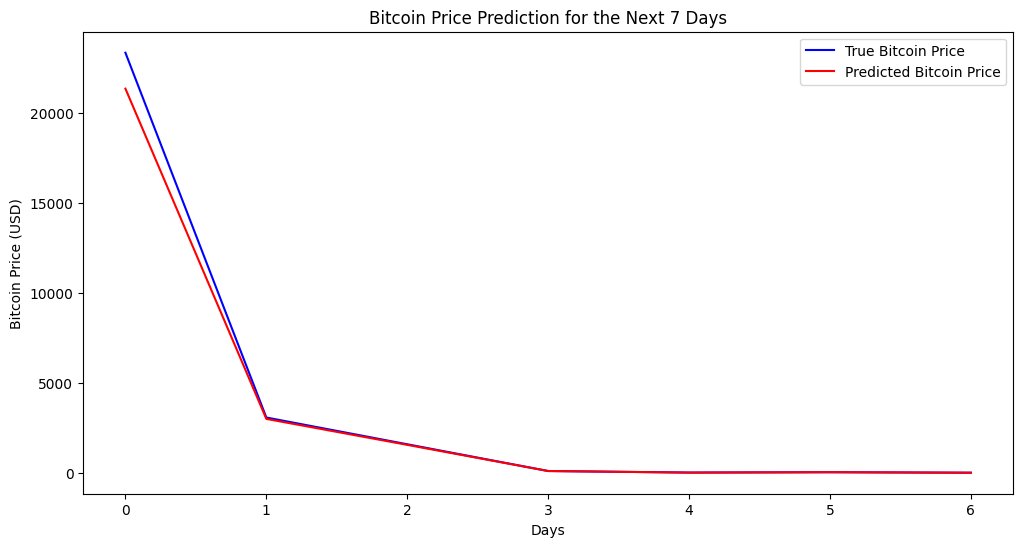

In [38]:
# Predicting the next 7 days for the test set
predictions = model.predict(X_test)

# Rescale predictions and true values back to original scale
predictions_rescaled = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 7))], axis=1))[:, :7]
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test, np.zeros((y_test.shape[0], scaled_data.shape[1] - 7))], axis=1))[:, :7]

# Show the predictions and the actual values for the next 7 days
print("Predictions (next 7 days):", predictions_rescaled)
print("True Values (next 7 days):", y_test_rescaled)

import matplotlib.pyplot as plt

# Plot predictions vs true values for a specific test sample
plt.figure(figsize=(12, 6))
plt.plot(range(7), y_test_rescaled[0], label='True Bitcoin Price', color='blue')
plt.plot(range(7), predictions_rescaled[0], label='Predicted Bitcoin Price', color='red')
plt.title('Bitcoin Price Prediction for the Next 7 Days')
plt.xlabel('Days')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()

In [8]:
# save model
model.save('oracle_v0.2.keras')
# save scaler
from pickle import dump
dump(scaler, open('minmax_scaler.pkl', 'wb'))

In [ ]:
last_60_days = scaled_data[-40:].reshape((1, 60, 7))  # Reshape to fit the model input

# Predict the next 7 days of Bitcoin price
predicted_prices = model.predict(last_60_days)

# Rescale the predicted prices back to the original Bitcoin price scale
predicted_prices_rescaled = scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], scaled_data.shape[1] - 7))], axis=1))[:, :7]

# Print the predicted prices for the next 7 days
print("Predicted Bitcoin Prices for the next 7 days:", predicted_prices_rescaled)

# Plot the prediction
plt.figure(figsize=(12, 6))
plt.plot(range(7), predicted_prices_rescaled[0], label='Predicted Bitcoin Price', color='red')
plt.title('Bitcoin Price Prediction for the Next 7 Days')
plt.xlabel('Days')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()

<Axes: >

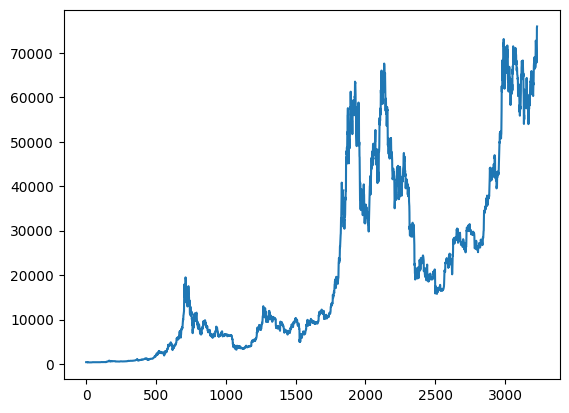

In [39]:
df['bitcoin_price'].plot()

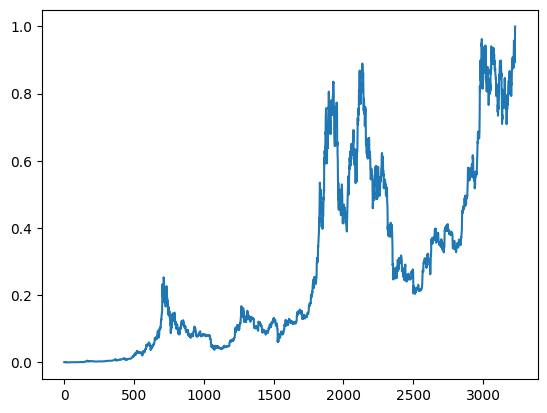

In [40]:
a = []
for i in range(len(scaled_data)):
    a.append(scaled_data[i][0])
plt.plot(a)